# Experiments notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.optimize import fmin, fsolve, minimize

from codes.utils import printoptions
from codes.graph_utils import Graph, spectral_gap
from codes.tasks import cifar10

import pandas as pd
import seaborn as sns

import time

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 20
sns.set(rc={'figure.figsize': (10, 3)})

## Graph

In [2]:
def get_neighbors_index(self, node, include_self):
    neighbors = []
    for i in range(self.n):
        if self.metropolis_weight[node][i] > 0:
            if not include_self and i == node:
                continue
            neighbors.append(i)
    return neighbors
    
def get_neighbors_weight(self, node, include_self): #wij given i, wij = wji
    indices = self.get_neighbors_index(node, include_self)
    weights = [self.metropolis_weight[node][j] for j in indices]
    return weights
    
def get_good_neighbors_index(self, node, include_self):
    indices = self.get_neighbors_index(node, include_self)
    return [i for i in indices if i >= self.b]

def delta_i(self, good_node):
    return sum(self.metropolis_weight[good_node, i] for i in range(self.b))

Graph.get_neighbors_index = get_neighbors_index
Graph.get_neighbors_weight = get_neighbors_weight
Graph.get_good_neighbors_index = get_good_neighbors_index
Graph.delta_i = delta_i

In [3]:
class TunableChain(Graph):

    def __init__(self, a, beta, b, n, mixing, delta_max, p):
        self.a = a
        self.beta = beta
        self.b = b
        self.delta_max = delta_max
        self.p = p
        self.n = n

        if delta_max > 1-a-beta:
            raise NotImplementedError

        metropolis = np.zeros((n, n))
        for i in range(n-b):
            for j in range(n-b):
                metropolis[i+b][j+b] = mixing[i][j]
        #metropolis[int(b):, int(b):] = mixing
        metropolis[0, 0] = 1 - delta_max
        metropolis[1, 1] = 1 - delta_max
        
        metropolis[0, 3] = delta_max
        metropolis[3, 0] = delta_max
        metropolis[3, 3] -= delta_max

        metropolis[1, 4] = delta_max
        metropolis[4, 1] = delta_max
        metropolis[4, 4] -= delta_max

        self.metropolis_weight = metropolis
    

In [4]:
class Ring(Graph):
    def __init__(self, n, b, delta_max):
        edges = [(i, i + 1) for i in range(n - 1)] + [(n - 1, 0)]

        self.n = n
        self.b = b
        
        metropolis = np.zeros((n, n))
        for (i, j) in edges:
            metropolis[i][i] = 1/3
            if i < self.b:
                metropolis[i][j] = delta_max
                metropolis[j][i] = delta_max
                metropolis[i][i] = 1-delta_max/2
            elif j < self.b:
                metropolis[i][j] = delta_max
                metropolis[j][i] = delta_max
                metropolis[i][i] = 1-delta_max/2
            else:
                metropolis[i][j] = 1/3
                metropolis[j][i] = 1/3
        self.metropolis_weight = metropolis

In [5]:
class Complete(Graph):
    def __init__(self, n, b, delta_max):
        edges = []
        for i in range(n - 1):
            for j in range(i + 1, n):
                edges.append((i, j))
        edges.append((n-1, n-1))
        self.n = n
        self.b = b
        
        metropolis = np.zeros((n, n))
        for (i, j) in edges:
            if j < self.b: #j == adv
                metropolis[i][j] = delta_max
                metropolis[j][i] = delta_max
                metropolis[i][i] = (1- delta_max*self.b) / (self.n-self.b)
            elif i < self.b: #i == adv
                metropolis[i][j] = delta_max
                metropolis[j][i] = delta_max
                metropolis[i][i] = (1- delta_max*self.b) / (self.n-self.b)
            else:
                metropolis[i][j] = (1- delta_max*self.b) / (self.n-self.b)
                metropolis[j][i] = (1- delta_max*self.b) / (self.n-self.b)
                metropolis[i][i] = (1- delta_max*self.b) / (self.n-self.b)
        self.metropolis_weight = metropolis

In [6]:
class Star(Graph):
    def __init__(self, n, b):
        edges = [(0, i) for i in range(1, n)]
        self.n = n
        self.b = b
        
        metropolis = np.zeros((n, n))
        for (i, j) in edges:
            metropolis[i][j] = 1
        self.metropolis_weight = metropolis

## Data

In [7]:
class DataManager(object):
    
    def __init__(self, data, graph, attacker):
        assert len(data) == graph.n - graph.b
        self.good_data = data
        self.graph = graph
        self.attacker = attacker
        attacker.configure(self, graph)
    
    def getDataOn(self, node):
        data = [self.attacker(i) for i in range(self.graph.b)] + self.good_data
        indices = self.graph.get_neighbors_index(node, include_self=True)
        return [data[i][node] for i in indices]

    def setGoodData(self, data):
        self.good_data = data

    def getGoodData(self, good_node):
        return self.good_data[good_node - self.graph.b][0]
    
    def getGoodState(self):
        data = self.good_data
        data = [data[i][i] for i in range(len(data))]
        return data
    
    def getStateOn(self, node):
        data = self.good_data
        return data[node - self.graph.b][node - self.graph.b]
    
def genGoodData(range_, l, N):
    data = []
    a, b = range_
    for i in range(l):
        data.append([random.randint(a, b)]*N)
    return data

## Experiments



In [8]:
class Experiment(object):

    def __init__(self, data_manager, graph, n, b, p, delta_max, T):
        # Number of workers
        self.n = n
        # Number of Byzantine workers
        self.b = b
        self.p = p
        self.delta_max = delta_max
        self.T = T

        self.data_manager = data_manager
        self.graph = graph
        self.mu0 = sum(data_manager.getGoodState()) / len(data_manager.getGoodState())

        self.consensus_distances = []
        self.errors = []

    def consensus_distance(self):
        data = self.data_manager.getGoodState()
        mu = sum(data) / len(data)
        return [(i - mu) ** 2 for i in data]

    def error(self):
        data = self.data_manager.getGoodState()
        return [(i - self.mu0) ** 2 for i in data]

    def run(self):
        self.consensus_distances.append(self.consensus_distance())
        self.errors.append(self.error())
        for t in range(self.T):
            new_data = []
            for i in range(self.b, self.n):
                # Aggregation on good worker i
                new_data.append(self.agg(i))

            self.data_manager.setGoodData(new_data)
            self.consensus_distances.append(self.consensus_distance())
            self.errors.append(self.error())

    def agg(self, i):
        raise NotImplementedError



# SSClip
def clip(v, tau):
    v_norm = abs(v)
    if v_norm == 0:
        return 0
    scale = min(1, tau / v_norm)
    return v * scale

def compute_tau(data, graph, i):
    b = graph.b
    delta_i = graph.delta_i(i)
    good_local_indices = graph.get_good_neighbors_index(i, include_self=True)
    tau = 0
    v = data[i-b][i]
    m = graph.metropolis_weight[i]
    for j in good_local_indices:
        w = m[j]
        d = data[j-b][j]
        distance = (d - v) ** 2
        tau += w * distance

    if delta_i == 0:
        tau = np.inf
    else:
        tau /= delta_i
        tau = np.sqrt(tau)
    return tau


class SSClip(Experiment):

    def agg(self, i):
        v = self.data_manager.getStateOn(i)

        delta_i = self.graph.delta_i(i)
        good_local_indices = self.graph.get_good_neighbors_index(i, include_self=False)

        tau = 0
        for j in good_local_indices:
            w = self.graph.metropolis_weight[i][j]
            d = self.data_manager.getStateOn(j)
            distance = (d - v) ** 2
            tau += w * distance
        
        if delta_i == 0:
            tau = np.inf
        else:
            tau /= delta_i
            tau = np.sqrt(tau)

        local_data = self.data_manager.getDataOn(i)
        weights = self.graph.get_neighbors_weight(i, include_self=True)
        new_data = 0
        a = []
        for index, vv, w in zip(self.graph.get_neighbors_index(i, include_self=True), local_data, weights):
            if vv == v:
                z = v
            else:
                z = v + clip(vv - v, tau)
            new_data += w * z
            a.append(f"Clip node {index} from {vv} to {z}")
        
        return [new_data]*self.n


class MedianWeighted(Experiment):

    def agg(self, i):
        _data = self.data_manager.getDataOn(i)
        mixing_weights = self.graph.get_neighbors_weight(i, include_self=True)
        N = 100
        data = []
        for d, w in zip(_data, mixing_weights):
            count = int(N * w)
            data += [d] * count

        sorted_data = sorted(data)
        mid_index = len(data) // 2
        if len(data) % 2:
            median = sorted_data[mid_index]
        else:
            median = (sorted_data[mid_index] + sorted_data[mid_index-1]) / 2
        return [median]*self.n

class TrimmedMeanWeighted(Experiment):

    def _get_n_byzantine_neighbor(self, i):
        # This function use strong knowledge
        if i == 2 or i == 5:
            return 0
        if i == 3 or i == 4:
            return 1
        raise NotImplementedError
        
    def agg(self, i):
        _data = self.data_manager.getDataOn(i)
        mixing_weights = self.graph.get_neighbors_weight(i, include_self=True)
        N = 100
        data = []
        for d, w in zip(_data, mixing_weights):
            count = int(N * w)
            data += [d] * count

        b = int(N * self.graph.delta_i(i))
        b = 49 if b >= 50 else b

        sorted_data = sorted(data)
        sorted_data = sorted_data[b:len(sorted_data) - b]
        return [sum(sorted_data) / len(sorted_data)]*self.n

class Median(Experiment):

    def agg(self, i):
        data = self.data_manager.getDataOn(i)
        sorted_data = sorted(data)
        mid_index = len(data) // 2
        if len(data) % 2:
            median = sorted_data[mid_index]
        else:
            median = (sorted_data[mid_index] + sorted_data[mid_index-1]) / 2
        return [median]*self.n

class TrimmedMean(Experiment):

    def _get_n_byzantine_neighbor(self, i):
        # This function use strong knowledge
        if i == 2 or i == 5:
            return 0
        if i == 3 or i == 4:
            return 1
        raise NotImplementedError
        
    def agg(self, i):
        b = self._get_n_byzantine_neighbor(i)
        data = self.data_manager.getDataOn(i)

        sorted_data = sorted(data)
        sorted_data = sorted_data[b:len(sorted_data) - b]
        return [sum(sorted_data) / len(sorted_data)]*self.n



## Attacks

### Jaggi's

In [9]:
class Attack(object):

    def configure(self, data_manager, graph):
        self.data_manager = data_manager
        self.graph = graph
        self.target = -1

    def __call__(self, byzantine_node):
        pass

class ConstValueAttack(Attack):
    def __init__(self, vs):
        self.vs = vs

    def __call__(self, byzantine_node):
        return [self.vs[byzantine_node]]*N
    
class DissensusAttack(Attack):
    def __init__(self, eps):
        self.eps = eps

    def __call__(self, byzantine_node):
        data = self.data_manager.good_data
        target = self.graph.get_good_neighbors_index(byzantine_node, False)[0]
        #target = 4 if byzantine_node else 3
        tm = self.data_manager.getStateOn(target)
        tw = self.graph.metropolis_weight[target]
        
        partial_sum = []
        for j in self.graph.get_good_neighbors_index(target, False):
            nm = self.data_manager.getStateOn(j)
            partial_sum.append((nm - tm)*tw[j])
        return [tm - self.eps * sum(partial_sum)/tw[byzantine_node]]*N
    

### Non Adaptive

In [10]:
class RandomAttack(Attack):
    def __init__(self, a, b, n):
        self.a = a
        self.b = b
        self.n = n
        
    def __call__(self, byzantine_node): 
        return [float(random.randint(self.a, self.b)) for i in range(self.n)]
       
    
class RandomConsistentAttack(Attack):
    def __init__(self, a, b, n):
        self.a = a
        self.b = b
        self.n = n
        
    def __call__(self, byzantine_node): 
        rand = float(random.randint(self.a, self.b))
        return [rand]*self.n
        
        
class InconsistentAttack(Attack):
    def __init__(self, a, b, byz, n):
        self.vs = [[float(random.randint(a, b)) for i in range(n)] for j in range(byz)]
        
    def __call__(self, byzantine_node): 
        return self.vs[byzantine_node]


### Adaptives

In [11]:
def find_min(guess, a, b, step, f):
    min_f, min_guess = f(guess), guess
    for i in range(a, b, step):
        if f(i) < min_f:
            min_f, min_guess = f(i), i
    return min_guess

#### StateOverride

In [12]:
class StateOverrideAttack(Attack):
    def __init__(self, target, n, b):        
        self.target = target
        self.n = n
        self.b = b
        
    def __call__(self, byzantine_node): 
        thetas = [0] * self.n
        data = self.data_manager.good_data
        
        for i in range(self.b, self.n):
            
            m = self.graph.metropolis_weight[i]
            if m[byzantine_node] == 0:
                continue
                
            neighbors = self.graph.get_neighbors_index(i, include_self=True)
            tau = compute_tau(data, self.graph, i)
            v = data[i-self.b][byzantine_node]
            
            network_contrib = 0
            for j in neighbors:
                if byzantine_node == j:
                    continue
                network_contrib += (v + clip(data[j-self.b][i] - v, tau))*m[j]
                
            def f(vv):
                return abs(network_contrib + (v + clip(vv - v, compute_tau(data, self.graph, i)))*m[byzantine_node] - self.target)

            vv = minimize(f, self.target -network_contrib, options={'maxiter':10}).x[0]
            thetas[i] = vv/m[byzantine_node]

        return thetas

#### SandTrap

In [13]:
class SandTrapAttack(Attack):

    def __init__(self, target, n, b):
        self.target = target
        self.n = n
        self.b = b

    def __call__(self, byzantine_node):
        thetas = [0] * self.n
        data = self.data_manager.good_data
        
        t = self.target
        v = data[t-self.b][byzantine_node]
        tau = compute_tau(data, self.graph, t)
        m = self.graph.metropolis_weight[t]
        neighbors = self.graph.get_neighbors_index(t, include_self=False)
        network_contrib = 0
        for j in neighbors:
            if byzantine_node == j:
                continue
            network_contrib += (v + clip(data[j-self.b][t] - v, tau))*m[j]

        def f(vv):
            return abs(network_contrib + (v + clip(vv - v, tau))*m[byzantine_node])
        
        inv_network_contrib = minimize(f, -network_contrib, options={'maxiter':10}).x[0]
        
        for i in range(self.b, self.n):
            
            if self.graph.metropolis_weight[i][byzantine_node] == 0:
                continue
                
            if i == t:
                thetas[i] = inv_network_contrib/m[byzantine_node]
            else:   
                thetas[i] = network_contrib/m[byzantine_node]
        return thetas

#### Echo

In [14]:
class EchoAttack(Attack):

    def __init__(self, target, n, b):
        self.n = n
        self.b = b
        self.target = target

    def __call__(self, byzantine_node):
        
        data = self.data_manager.good_data  
        t = self.target
        thetas = [0]*self.n
        if t == -1:
            for i in range(self.b, self.n):
                if self.graph.metropolis_weight[i][byzantine_node] != 0:
                    v = data[i-self.b][byzantine_node] 
                    def f(vv):
                        return abs(clip(vv - v, compute_tau(data, self.graph, i)) - v)
                    
                    vv = minimize(f, v, options={'maxiter':10}).x[0]
                    thetas[i] = vv/self.graph.metropolis_weight[i][byzantine_node]

        else:
            v = data[t-self.b][byzantine_node]
            def f(vv):
                return abs(clip(vv - v, compute_tau(data, self.graph, t)) - v)
            
            vv = minimize(f, v, options={'maxiter':10}).x[0]            
            for i in range(self.b, self.n):
                if self.graph.metropolis_weight[i][byzantine_node] != 0:
                    thetas[i] = vv/self.graph.metropolis_weight[i][byzantine_node]
        return thetas

## Plots

In [15]:
def plot_res(results, file_name):
    stats = []
    for res in results:
        delta_max, p = res['exp'].delta_max, res['exp'].p
        if res['defense'].endswith("*"):
            continue
        if res['attack'] == "constant":
            continue
        for t, es, cds in zip(range(res['exp'].T+1), res['exp'].errors, res['exp'].consensus_distances):
            if t > 100:
                break
            for i in range(len(es)):
                if (i+b) == res["target"]:
                    stats.append({r"$\delta_{\max}$ value": delta_max, "p_value": p, "Error": es[i], "Target": True, r"$\Xi$": cds[i], "T": t, "Agg": res['defense']})
                else:
                    stats.append({r"$\delta_{\max}$ value": delta_max, "p_value": p, "Error": es[i], "Target": False, r"$\Xi$": cds[i], "T": t, "Agg": res['defense']})


    df = pd.DataFrame(stats)
    df = df[df['T'] == 100]
    df[r'$\delta$'] = df[r"$\delta_{\max}$ value"]
    df[r'$\delta/p$'] = df[r"$\delta_{\max}$ value"] / df['p_value'] ** 1
    df[r'$\delta/\gamma^2$'] = df[r"$\delta_{\max}$ value"] / df['p_value'].apply(lambda p: (1- np.sqrt(1-p)) ** 2)
    df[r'$1/\gamma^2$'] = 1 / df['p_value'].apply(lambda p: (1- np.sqrt(1-p)) ** 2)
    df[r'$\delta/p^2$'] = df[r"$\delta_{\max}$ value"] / df['p_value'] ** 2

    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 11
    sns.set(rc={'figure.figsize': (6., 2)})
    fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True)

    max_ = df["Error"].max()
    
    g = sns.scatterplot(data=df, x=r'$\delta/\gamma^2$', y="Error", hue="Agg", ax=axes[2], style="Target", legend=False)
    g.set_xscale('log')
    g.set_yscale('log')
    g.get_xaxis().set_ticklabels([])
    #g.get_yaxis().set_ticks([0])

    axes[2].axvline(x=100000, color='r', alpha=0.5, ls='--')
    axes[2].axvline(x=2*10**11, color='r', alpha=0.5, ls='--')


    g = sns.scatterplot(data=df, x=r'$\delta$', y="Error", hue="Agg", ax=axes[1], style="Target")
    g.set_xscale('log')
    g.set_yscale('log')
    g.get_xaxis().set_ticklabels([])

    g = sns.scatterplot(data=df, x=r'$1/\gamma^2$', y="Error", hue="Agg", ax=axes[0], style="Target", legend=False)
    g.set_xscale('log')
    g.set_yscale('log')
    g.get_xaxis().set_ticklabels([])

    axes[0].set_ylabel('Error', labelpad=8)
    fig.subplots_adjust(wspace=0.093)

    axes[0].set_ylim()
    axes[1].legend(loc="lower left",  ncol=3, borderaxespad=0, bbox_to_anchor=(-0.6, 1.02, 1, 0.2))

    fig.savefig(file_name, bbox_inches="tight", dpi=720)

In [16]:
N = 6
b = 2
data0 = [[0]*N, [0]*N, [200]*N, [200]*N]
a = 1/3
target = 3

# TUNABLE CHAIN


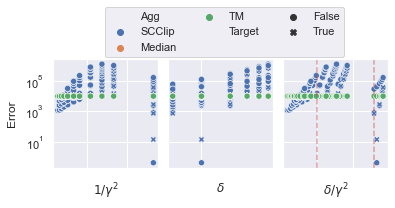

In [17]:
results = []
for attacker, attack_name in [(EchoAttack(target, N, b), "echo")]:
    for Defense, defense_name in [(SSClip, "SCClip"), (Median, "Median"), (TrimmedMean, "TM"),
    (MedianWeighted, "Median*"), (TrimmedMeanWeighted, "TM*")]:
        for delta_max in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]:
            for beta in [0.58, 0.45, 0.35, 0.267, 0.19, 0.12, 0.08, 0.04, 0.02, 0.01, 1e-3]:
                mixing = np.array([
                    [1-a, a, 0, 0],
                    [a, 1-a-beta, beta, 0],
                    [0, beta, 1-a-beta,a],
                    [0, 0, a, 1-a]
                ])
                p = spectral_gap(mixing) ** 2
                try:
                    graph = TunableChain(a, beta, b, N, mixing, delta_max=delta_max, p=p)
                    data_manager = DataManager(data0, graph, attacker)
                    runner = Defense(data_manager, graph, N, b, p, delta_max, 100)
                    runner.run()
                    results.append({"exp": runner, "attack": attack_name, "target": target, "defense": defense_name, 'beta': beta})
                except:
                    pass
                
plot_res(results, "./error_plots_clip/chain_consensus_echo_target_clip.pdf")


In [ ]:
results = []
for attacker, attack_name in [(EchoAttack(-1, N, b), "echo_gen")]:
    for Defense, defense_name in [(SSClip, "SCClip"), (Median, "Median"), (TrimmedMean, "TM"),
    (MedianWeighted, "Median*"), (TrimmedMeanWeighted, "TM*")]:
        for delta_max in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]:
            for beta in [0.58, 0.45, 0.35, 0.267, 0.19, 0.12, 0.08, 0.04, 0.02, 0.01, 1e-3]:
                mixing = np.array([
                    [1-a, a, 0, 0],
                    [a, 1-a-beta, beta, 0],
                    [0, beta, 1-a-beta,a],
                    [0, 0, a, 1-a]
                ])
                p = spectral_gap(mixing) ** 2
                try:
                    graph = TunableChain(a, beta, b, N, mixing, delta_max=delta_max, p=p)
                    data_manager = DataManager(data0, graph, attacker)
                    runner = Defense(data_manager, graph, N, b, p, delta_max, 100)
                    runner.run()
                    results.append({"exp": runner, "attack": attack_name, "target": -1, "defense": defense_name, 'beta': beta})
                except:
                    pass
plot_res(results, "./error_plots_clip/chain_consensus_echo_gen_target_clip.pdf")

In [ ]:
results = []
for attacker, attack_name in [(DissensusAttack(0.05), "dissensus0.05")]:
    for Defense, defense_name in [(SSClip, "SCClip"), (Median, "Median"), (TrimmedMean, "TM"),
    (MedianWeighted, "Median*"), (TrimmedMeanWeighted, "TM*")]:
        for delta_max in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]:
            for beta in [0.58, 0.45, 0.35, 0.267, 0.19, 0.12, 0.08, 0.04, 0.02, 0.01, 1e-3]:
                mixing = np.array([
                    [1-a, a, 0, 0],
                    [a, 1-a-beta, beta, 0],
                    [0, beta, 1-a-beta,a],
                    [0, 0, a, 1-a]
                ])
                p = spectral_gap(mixing) ** 2
                try:
                    graph = TunableChain(a, beta, b, N, mixing, delta_max=delta_max, p=p)
                    data_manager = DataManager(data0, graph, attacker)
                    runner = Defense(data_manager, graph, N, b, p, delta_max, 100)
                    runner.run()
                    results.append({"exp": runner, "attack": attack_name, "target": target, "defense": defense_name, 'beta': beta})
                except:
                    pass
plot_res(results, "./error_plots_clip/chain_consensus_dissensus_target_clip.pdf")

In [ ]:
results = []
for attacker, attack_name in [(SandTrapAttack(target, N, b), "sandtrap")]:
    for Defense, defense_name in [(SSClip, "SCClip"), (Median, "Median"), (TrimmedMean, "TM"),
    (MedianWeighted, "Median*"), (TrimmedMeanWeighted, "TM*")]:
        for delta_max in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]:
            for beta in [0.58, 0.45, 0.35, 0.267, 0.19, 0.12, 0.08, 0.04, 0.02, 0.01, 1e-3]:
                mixing = np.array([
                    [1-a, a, 0, 0],
                    [a, 1-a-beta, beta, 0],
                    [0, beta, 1-a-beta,a],
                    [0, 0, a, 1-a]
                ])
                p = spectral_gap(mixing) ** 2
                try:
                    graph = TunableChain(a, beta, b, N, mixing, delta_max=delta_max, p=p)
                    data_manager = DataManager(data0, graph, attacker)
                    runner = Defense(data_manager, graph, N, b, p, delta_max, 100)
                    runner.run()
                    results.append({"exp": runner, "attack": attack_name, "target": target, "defense": defense_name, 'beta': beta})
                except:
                    pass
plot_res(results, "./error_plots_clip/chain_consensus_sandtrap_target_clip.pdf")

In [ ]:
results = []
targets = [-100, 0, 1000]
for t, attacker, attack_name in [(t, StateOverrideAttack(t, N, b), "stateoverride") for t in targets]:
    for Defense, defense_name in [(SSClip, "SCClip"), (Median, "Median"), (TrimmedMean, "TM"),
    (MedianWeighted, "Median*"), (TrimmedMeanWeighted, "TM*")]:
        for delta_max in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]:
            for beta in [0.58, 0.45, 0.35, 0.267, 0.19, 0.12, 0.08, 0.04, 0.02, 0.01, 1e-3]:
                mixing = np.array([
                    [1-a, a, 0, 0],
                    [a, 1-a-beta, beta, 0],
                    [0, beta, 1-a-beta,a],
                    [0, 0, a, 1-a]
                ])
                p = spectral_gap(mixing) ** 2
                try:
                    graph = TunableChain(a, beta, b, N, mixing, delta_max=delta_max, p=p)
                    data_manager = DataManager(data0, graph, attacker)
                    runner = Defense(data_manager, graph, N, b, p, delta_max, 100)
                    runner.run()
                    results.append({"exp": runner, "attack": attack_name, "target": t, "defense": defense_name, 'beta': beta})
                except:
                    pass
    plot_res(results, "./error_plots_clip/chain_consensus_override" + str(t) + "_target_clip.pdf")

# COMPLETE

In [ ]:
results = []
for attacker, attack_name in [(EchoAttack(target, N, b), "echo")]:
    for Defense, defense_name in [(SSClip, "SCClip"), (Median, "Median"), (TrimmedMean, "TM"),
    (MedianWeighted, "Median*"), (TrimmedMeanWeighted, "TM*")]:
        for delta_max in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1/N]:
            try:
                graph = Complete(N, b, delta_max)
                data_manager = DataManager(data0, graph, attacker)
                runner = Defense(data_manager, graph, N, b, spectral_gap(graph.metropolis_weight), delta_max, 100)
                runner.run()
                results.append({"exp": runner, "attack": attack_name, "target": target, "defense": defense_name, 'beta': beta})
            except:
                pass
plot_res(results, "./error_plots_clip/complete_consensus_echo_target_clip.pdf")

In [ ]:
results = []
for attacker, attack_name in [(EchoAttack(-1, N, b), "echo_gen")]:
    for Defense, defense_name in [(SSClip, "SCClip"), (Median, "Median"), (TrimmedMean, "TM"),
    (MedianWeighted, "Median*"), (TrimmedMeanWeighted, "TM*")]:
        for delta_max in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1/N]:
            try:
                graph = Complete(N, b, delta_max)
                data_manager = DataManager(data0, graph, attacker)
                runner = Defense(data_manager, graph, N, b, spectral_gap(graph.metropolis_weight), delta_max, 100)
                runner.run()
                results.append({"exp": runner, "attack": attack_name, "target": -1, "defense": defense_name, 'beta': beta})
            except:
                pass
plot_res(results, "./error_plots_clip/complete_consensus_echo_gen_target_clip.pdf")

In [ ]:
results = []
for attacker, attack_name in [(DissensusAttack(0.05), "dissensus0.05")]:
    for Defense, defense_name in [(SSClip, "SCClip"), (Median, "Median"), (TrimmedMean, "TM"),
    (MedianWeighted, "Median*"), (TrimmedMeanWeighted, "TM*")]:
        for delta_max in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1/N]:
            try:
                graph = Complete(N, b, delta_max)
                data_manager = DataManager(data0, graph, attacker)
                runner = Defense(data_manager, graph, N, b, spectral_gap(graph.metropolis_weight), delta_max, 100)
                runner.run()
                results.append({"exp": runner, "attack": attack_name, "target": target, "defense": defense_name, 'beta': beta})
            except:
                pass
plot_res(results, "./error_plots_clip/complete_consensus_dissensus_target_clip.pdf")

In [ ]:
a = 1 / 3
results = []
for attacker, attack_name in [(SandTrapAttack(target, N, b), "sandtrap")]:
    for Defense, defense_name in [(SSClip, "SCClip"), (Median, "Median"), (TrimmedMean, "TM"),
    (MedianWeighted, "Median*"), (TrimmedMeanWeighted, "TM*")]:
        for delta_max in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1/N]:
            try:
                graph = Complete(N, b, delta_max)
                data_manager = DataManager(data0, graph, attacker)
                runner = Defense(data_manager, graph, N, b, spectral_gap(graph.metropolis_weight), delta_max, 100)
                runner.run()
                results.append({"exp": runner, "attack": attack_name, "target": target, "defense": defense_name, 'beta': beta})
            except:
                pass
plot_res(results, "./error_plots_clip/complete_consensus_sandtrap_target_clip.pdf")


In [ ]:
results = []
targets = [-100, 0, 300]
for t, attacker, attack_name in [(t, StateOverrideAttack(t, N, b), "override") for t in targets]:
    for Defense, defense_name in [(SSClip, "SCClip"), (Median, "Median"), (TrimmedMean, "TM"),
    (MedianWeighted, "Median*"), (TrimmedMeanWeighted, "TM*")]:
        for delta_max in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1/N]:
            try:
                graph = Complete(N, b, delta_max)
                data_manager = DataManager(data0, graph, attacker)
                runner = Defense(data_manager, graph, N, b, spectral_gap(graph.metropolis_weight), delta_max, 100)
                runner.run()
                results.append({"exp": runner, "attack": attack_name, "target": target, "defense": defense_name, 'beta': beta})
            except:
                pass
    plot_res(results, "./error_plots/complete_consensus_override"+str(t)+"_target_grad.pdf")

# RING

In [ ]:
results = []
for attacker, attack_name in [(EchoAttack(N-1, N, b), "echo")]:
    for Defense, defense_name in [(SSClip, "SCClip"), (Median, "Median"), (TrimmedMean, "TM"),
    (MedianWeighted, "Median*"), (TrimmedMeanWeighted, "TM*")]:
        for delta_max in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1/3]:
            try:
                graph = Ring(N, b, delta_max)
                data_manager = DataManager(data0, graph, attacker)
                runner = Defense(data_manager, graph, N, b, spectral_gap(graph.metropolis_weight), delta_max, 100)
                runner.run()
                results.append({"exp": runner, "attack": attack_name, "target": target, "defense": defense_name, 'beta': beta})
            except:
                pass
plot_res(results, "./error_plots_clip/ring_consensus_echo_target_clip.pdf")


In [ ]:
results = []
for attacker, attack_name in [(EchoAttack(-1, N, b), "echo_gen")]:
    for Defense, defense_name in [(SSClip, "SCClip"), (Median, "Median"), (TrimmedMean, "TM"),
    (MedianWeighted, "Median*"), (TrimmedMeanWeighted, "TM*")]:
        for delta_max in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1/3]:
            try:
                graph = Ring(N, b, delta_max)
                data_manager = DataManager(data0, graph, attacker)
                runner = Defense(data_manager, graph, N, b, spectral_gap(graph.metropolis_weight), delta_max, 100)
                runner.run()
                results.append({"exp": runner, "attack": attack_name, "target": -1, "defense": defense_name, 'beta': beta})
            except:
                pass
plot_res(results, "./error_plots_clip/ring_consensus_echo_gen_target_clip.pdf")


In [ ]:
results = []
for attacker, attack_name in [(DissensusAttack(0.05), "dissensus0.05")]:
    for Defense, defense_name in [(SSClip, "SCClip"), (Median, "Median"), (TrimmedMean, "TM"),
    (MedianWeighted, "Median*"), (TrimmedMeanWeighted, "TM*")]:
        for delta_max in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1/3]:
            try:
                graph = Ring(N, b, delta_max)
                data_manager = DataManager(data0, graph, attacker)
                runner = Defense(data_manager, graph, N, b, spectral_gap(graph.metropolis_weight), delta_max, 100)
                runner.run()
                results.append({"exp": runner, "attack": attack_name, "target": target, "defense": defense_name, 'beta': beta})
            except:
                pass
            
plot_res(results, "./error_plots_clip/ring_consensus_dissensus_target_clip.pdf")


In [ ]:
results = []
for attacker, attack_name in [(SandTrapAttack(N-1, N, b), "sandtrap")]:
    for Defense, defense_name in [(SSClip, "SCClip"), (Median, "Median"), (TrimmedMean, "TM"),
    (MedianWeighted, "Median*"), (TrimmedMeanWeighted, "TM*")]:
        for delta_max in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1/3]:
            try:
                graph = Ring(N, b, delta_max)
                data_manager = DataManager(data0, graph, attacker)
                runner = Defense(data_manager, graph, N, b, spectral_gap(graph.metropolis_weight), delta_max, 100)
                runner.run()
                results.append({"exp": runner, "attack": attack_name, "target": target, "defense": defense_name, 'beta': beta})
            except:
                pass
plot_res(results, "./error_plots_clip/ring_consensus_sandtrap_target_clip.pdf")


In [ ]:
results = []
targets = [-100, 0, 300]
for t, attacker, attack_name in [(t, StateOverrideAttack(t, N, b), "override") for t in targets]:
    for Defense, defense_name in [(SSClip, "SCClip"), (Median, "Median"), (TrimmedMean, "TM"),
    (MedianWeighted, "Median*"), (TrimmedMeanWeighted, "TM*")]:
        for delta_max in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1/N]:
            try:
                graph = Ring(N, b, delta_max)
                data_manager = DataManager(data0, graph, attacker)
                runner = Defense(data_manager, graph, N, b, spectral_gap(graph.metropolis_weight), delta_max, 100)
                runner.run()
                results.append({"exp": runner, "attack": attack_name, "target": target, "defense": defense_name, 'beta': beta})
            except:
                pass
    plot_res(results, "./error_plots/ring_consensus_override"+str(t)+"_target_clip.pdf")

# Aggregate of errors

In [ ]:
def consensus_distance(self):
    data = self.data_manager.getGoodState()
    mu = sum(data) / len(data)
    return sum((i - mu) ** 2 for i in data)/len(data)

def error(self):
    data = self.data_manager.getGoodState()
    return sum((i - self.mu0) ** 2 for i in data) / len(data)

Experiment.consensus_distance = consensus_distance
Experiment.error = error

def plot_res(results, file_name):
    stats = []
    for res in results:
        delta_max, p = res['exp'].delta_max, res['exp'].p
        if res['defense'].endswith("*"):
            continue
        if res['attack'] == "constant":
            continue
        for t, e, cd in zip(range(res['exp'].T+1), res['exp'].errors, res['exp'].consensus_distances):
            if t > 100:
                break
            stats.append({r"$\delta_{\max}$ value": delta_max, "p_value": p, "Error": e, r"$\Xi$": cd, "T": t, "Agg": res['defense']})


    df = pd.DataFrame(stats)
    df = df[df['T'] == 100]
    df[r'$\delta$'] = df[r"$\delta_{\max}$ value"]
    df[r'$\delta/p$'] = df[r"$\delta_{\max}$ value"] / df['p_value'] ** 1
    df[r'$\delta/\gamma^2$'] = df[r"$\delta_{\max}$ value"] / df['p_value'].apply(lambda p: (1- np.sqrt(1-p)) ** 2)
    df[r'$1/\gamma^2$'] = 1 / df['p_value'].apply(lambda p: (1- np.sqrt(1-p)) ** 2)
    df[r'$\delta/p^2$'] = df[r"$\delta_{\max}$ value"] / df['p_value'] ** 2

    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 11
    sns.set(rc={'figure.figsize': (6., 2)})
    fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True)

    g = sns.scatterplot(data=df, x=r'$\delta/\gamma^2$', y="Error", hue="Agg", ax=axes[2], legend=False)
    g.set_xscale('log')
    g.set_yscale('log')
    g.get_xaxis().set_ticklabels([])
    #g.get_yaxis().set_ticks([0])

    axes[2].axvline(x=100000, color='r', alpha=0.5, ls='--')
    axes[2].axvline(x=2*10**11, color='r', alpha=0.5, ls='--')


    g = sns.scatterplot(data=df, x=r'$\delta$', y="Error", hue="Agg", ax=axes[1], )
    g.set_xscale('log')
    g.set_yscale('log')
    g.get_xaxis().set_ticklabels([])

    g = sns.scatterplot(data=df, x=r'$1/\gamma^2$', y="Error", hue="Agg", ax=axes[0], legend=False)
    g.set_xscale('log')
    g.set_yscale('log')
    g.get_xaxis().set_ticklabels([])

    axes[0].set_ylabel('Error', labelpad=8)
    fig.subplots_adjust(wspace=0.093)

    axes[1].legend(loc="lower left",  ncol=3, borderaxespad=0, bbox_to_anchor=(-0.6, 1.02, 1, 0.2))

    fig.savefig(file_name, bbox_inches="tight", dpi=720)

In [ ]:
results = []
for attacker, attack_name in [(EchoAttack(target, N, b), "echo")]:
    for Defense, defense_name in [(SSClip, "SCClip"), (Median, "Median"), (TrimmedMean, "TM"),
    (MedianWeighted, "Median*"), (TrimmedMeanWeighted, "TM*")]:
        for delta_max in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]:
            for beta in [0.58, 0.45, 0.35, 0.267, 0.19, 0.12, 0.08, 0.04, 0.02, 0.01, 1e-3]:
                mixing = np.array([
                    [1-a, a, 0, 0],
                    [a, 1-a-beta, beta, 0],
                    [0, beta, 1-a-beta,a],
                    [0, 0, a, 1-a]
                ])
                p = spectral_gap(mixing) ** 2
                try:
                    graph = TunableChain(a, beta, b, N, mixing, delta_max=delta_max, p=p)
                    data_manager = DataManager(data0, graph, attacker)
                    runner = Defense(data_manager, graph, N, b, p, delta_max, 100)
                    runner.run()
                    results.append({"exp": runner, "attack": attack_name, "defense": defense_name, 'beta': beta})
                except:
                    pass
plot_res(results, "./error_plots_clip/chain_consensus_echo_clip.pdf")

In [ ]:
results = []
for attacker, attack_name in [(EchoAttack(-1, N, b), "echo_gen")]:
    for Defense, defense_name in [(SSClip, "SCClip"), (Median, "Median"), (TrimmedMean, "TM"),
    (MedianWeighted, "Median*"), (TrimmedMeanWeighted, "TM*")]:
        for delta_max in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]:
            for beta in [0.58, 0.45, 0.35, 0.267, 0.19, 0.12, 0.08, 0.04, 0.02, 0.01, 1e-3]:
                mixing = np.array([
                    [1-a, a, 0, 0],
                    [a, 1-a-beta, beta, 0],
                    [0, beta, 1-a-beta,a],
                    [0, 0, a, 1-a]
                ])
                p = spectral_gap(mixing) ** 2
                try:
                    graph = TunableChain(a, beta, b, N, mixing, delta_max=delta_max, p=p)
                    data_manager = DataManager(data0, graph, attacker)
                    runner = Defense(data_manager, graph, N, b, p, delta_max, 100)
                    runner.run()
                    results.append({"exp": runner, "attack": attack_name, "defense": defense_name, 'beta': beta})
                except:
                    pass
plot_res(results, "./error_plots_clip/chain_consensus_echo_gen_clip.pdf")

In [ ]:
results = []
for attacker, attack_name in [(DissensusAttack(0.05), "dissensus")]:
    for Defense, defense_name in [(SSClip, "SCClip"), (Median, "Median"), (TrimmedMean, "TM"),
    (MedianWeighted, "Median*"), (TrimmedMeanWeighted, "TM*")]:
        for delta_max in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]:
            for beta in [0.58, 0.45, 0.35, 0.267, 0.19, 0.12, 0.08, 0.04, 0.02, 0.01, 1e-3]:
                mixing = np.array([
                    [1-a, a, 0, 0],
                    [a, 1-a-beta, beta, 0],
                    [0, beta, 1-a-beta,a],
                    [0, 0, a, 1-a]
                ])
                p = spectral_gap(mixing) ** 2
                try:
                    graph = TunableChain(a, beta, b, N, mixing, delta_max=delta_max, p=p)
                    data_manager = DataManager(data0, graph, attacker)
                    runner = Defense(data_manager, graph, N, b, p, delta_max, 100)
                    runner.run()
                    results.append({"exp": runner, "attack": attack_name, "defense": defense_name, 'beta': beta})
                except:
                    pass
plot_res(results, "./error_plots_clip/chain_consensus_dissensus_clip.pdf")

In [ ]:
results = []
for attacker, attack_name in [(SandTrapAttack(target, N, b), "sandtrap")]:
    for Defense, defense_name in [(SSClip, "SCClip"), (Median, "Median"), (TrimmedMean, "TM"),
    (MedianWeighted, "Median*"), (TrimmedMeanWeighted, "TM*")]:
        for delta_max in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]:
            for beta in [0.58, 0.45, 0.35, 0.267, 0.19, 0.12, 0.08, 0.04, 0.02, 0.01, 1e-3]:
                mixing = np.array([
                    [1-a, a, 0, 0],
                    [a, 1-a-beta, beta, 0],
                    [0, beta, 1-a-beta,a],
                    [0, 0, a, 1-a]
                ])
                p = spectral_gap(mixing) ** 2
                try:
                    graph = TunableChain(a, beta, b, N, mixing, delta_max=delta_max, p=p)
                    data_manager = DataManager(data0, graph, attacker)
                    runner = Defense(data_manager, graph, N, b, p, delta_max, 100)
                    runner.run()
                    results.append({"exp": runner, "attack": attack_name, "defense": defense_name, 'beta': beta})
                except:
                    pass
plot_res(results, "./error_plots_clip/chain_consensus_sandtrap_clip.pdf")

In [ ]:
results = []
targets = [-100, 0, 300]
for t, attacker, attack_name in [(t, StateOverrideAttack(t, N, b), "override") for t in targets]:
    for Defense, defense_name in [(SSClip, "SCClip"), (Median, "Median"), (TrimmedMean, "TM"),
    (MedianWeighted, "Median*"), (TrimmedMeanWeighted, "TM*")]:
        for delta_max in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]:
            for beta in [0.58, 0.45, 0.35, 0.267, 0.19, 0.12, 0.08, 0.04, 0.02, 0.01, 1e-3]:
                mixing = np.array([
                    [1-a, a, 0, 0],
                    [a, 1-a-beta, beta, 0],
                    [0, beta, 1-a-beta,a],
                    [0, 0, a, 1-a]
                ])
                p = spectral_gap(mixing) ** 2
                try:
                    graph = TunableChain(a, beta, b, N, mixing, delta_max=delta_max, p=p)
                    data_manager = DataManager(data0, graph, attacker)
                    runner = Defense(data_manager, graph, N, b, p, delta_max, 100)
                    runner.run()
                    results.append({"exp": runner, "attack": attack_name, "defense": defense_name, 'beta': beta})
                except:
                    pass
    plot_res(results, "./error_plots/chain_consensus_override"+str(t)+"_clip.pdf")

In [ ]:
results = []
for attacker, attack_name in [(EchoAttack(target, N, b), "echo")]:
    for Defense, defense_name in [(SSClip, "SCClip"), (Median, "Median"), (TrimmedMean, "TM"),
    (MedianWeighted, "Median*"), (TrimmedMeanWeighted, "TM*")]:
        for delta_max in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1/N]:
            try:
                graph = Complete(N, b, delta_max)
                data_manager = DataManager(data0, graph, attacker)
                runner = Defense(data_manager, graph, N, b, spectral_gap(graph.metropolis_weight), delta_max, 100)
                runner.run()
                results.append({"exp": runner, "attack": attack_name, "target": target, "defense": defense_name, 'beta': beta})
            except:
                pass
            
plot_res(results, "./error_plots_clip/complete_consensus_echo_clip.pdf")

In [ ]:
results = []
for attacker, attack_name in [(EchoAttack(-1, N, b), "echo_gen")]:
    for Defense, defense_name in [(SSClip, "SCClip"), (Median, "Median"), (TrimmedMean, "TM"),
    (MedianWeighted, "Median*"), (TrimmedMeanWeighted, "TM*")]:
        for delta_max in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1/N]:
            try:
                graph = Complete(N, b, delta_max)
                data_manager = DataManager(data0, graph, attacker)
                runner = Defense(data_manager, graph, N, b, spectral_gap(graph.metropolis_weight), delta_max, 100)
                runner.run()
                results.append({"exp": runner, "attack": attack_name, "target": -1, "defense": defense_name, 'beta': beta})
            except:
                pass
plot_res(results, "./error_plots_clip/complete_consensus_echo_gen_clip.pdf")


In [ ]:
results = []
for attacker, attack_name in [(DissensusAttack(0.05), "dissensus")]:
    for Defense, defense_name in [(SSClip, "SCClip"), (Median, "Median"), (TrimmedMean, "TM"),
    (MedianWeighted, "Median*"), (TrimmedMeanWeighted, "TM*")]:
        for delta_max in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1/N]:
            try:
                graph = Complete(N, b, delta_max)
                data_manager = DataManager(data0, graph, attacker)
                runner = Defense(data_manager, graph, N, b, spectral_gap(graph.metropolis_weight), delta_max, 100)
                runner.run()
                results.append({"exp": runner, "attack": attack_name, "target": target, "defense": defense_name, 'beta': beta})
            except:
                pass
plot_res(results, "./error_plots_clip/complete_consensus_dissensus_clip.pdf")


In [ ]:
results = []
for attacker, attack_name in [(SandTrapAttack(N-1, N, b), "sandtrap")]:
    for Defense, defense_name in [(SSClip, "SCClip"), (Median, "Median"), (TrimmedMean, "TM"),
    (MedianWeighted, "Median*"), (TrimmedMeanWeighted, "TM*")]:
        for delta_max in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1/N]:
            try:
                graph = Complete(N, b, delta_max)
                data_manager = DataManager(data0, graph, attacker)
                runner = Defense(data_manager, graph, N, b, spectral_gap(graph.metropolis_weight), delta_max, 100)
                runner.run()
                results.append({"exp": runner, "attack": attack_name, "target": target, "defense": defense_name, 'beta': beta})
            except:
                pass
plot_res(results, "./error_plots_clip/complete_consensus_sandtrap_clip.pdf")


In [ ]:
results = []
targets = [-100, 0, 300]
for t, attacker, attack_name in [(t, StateOverrideAttack(t, N, b), "override") for t in targets]:
    for Defense, defense_name in [(SSClip, "SCClip"), (Median, "Median"), (TrimmedMean, "TM"),
    (MedianWeighted, "Median*"), (TrimmedMeanWeighted, "TM*")]:
        for delta_max in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1/N]:
            try:
                graph = Complete(N, b, delta_max)
                data_manager = DataManager(data0, graph, attacker)
                runner = Defense(data_manager, graph, N, b, spectral_gap(graph.metropolis_weight), delta_max, 100)
                runner.run()
                results.append({"exp": runner, "attack": attack_name, "target": target, "defense": defense_name, 'beta': beta})
            except:
                pass
    plot_res(results, "./error_plots/complete_consensus_override"+str(t)+"_clip.pdf")

In [ ]:
results = []
for attacker, attack_name in [(EchoAttack(target, N, b), "echo")]:
    for Defense, defense_name in [(SSClip, "SCClip"), (Median, "Median"), (TrimmedMean, "TM"),
    (MedianWeighted, "Median*"), (TrimmedMeanWeighted, "TM*")]:
        for delta_max in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1/3]:
            try:
                graph = Ring(N, b, delta_max)
                data_manager = DataManager(data0, graph, attacker)
                runner = Defense(data_manager, graph, N, b, spectral_gap(graph.metropolis_weight), delta_max, 100)
                runner.run()
                results.append({"exp": runner, "attack": attack_name, "target": target, "defense": defense_name, 'beta': beta})
            except:
                pass
plot_res(results, "./error_plots_clip/ring_consensus_echo_clip.pdf")


In [ ]:
results = []
for attacker, attack_name in [(EchoAttack(-1, N, b), "echo_gen")]:
    for Defense, defense_name in [(SSClip, "SCClip"), (Median, "Median"), (TrimmedMean, "TM"),
    (MedianWeighted, "Median*"), (TrimmedMeanWeighted, "TM*")]:
        for delta_max in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1/3]:
            try:
                graph = Ring(N, b, delta_max)
                data_manager = DataManager(data0, graph, attacker)
                runner = Defense(data_manager, graph, N, b, spectral_gap(graph.metropolis_weight), delta_max, 100)
                runner.run()
                results.append({"exp": runner, "attack": attack_name, "target": -1, "defense": defense_name, 'beta': beta})
            except:
                pass
plot_res(results, "./error_plots_clip/ring_consensus_echo_gen_clip.pdf")


In [ ]:
results = []
for attacker, attack_name in [(DissensusAttack(0.05), "dissensus")]:
    for Defense, defense_name in [(SSClip, "SCClip"), (Median, "Median"), (TrimmedMean, "TM"),
    (MedianWeighted, "Median*"), (TrimmedMeanWeighted, "TM*")]:
        for delta_max in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1/N]:
            try:
                graph = Ring(N, b, delta_max)
                data_manager = DataManager(data0, graph, attacker)
                runner = Defense(data_manager, graph, N, b, spectral_gap(graph.metropolis_weight), delta_max, 100)
                runner.run()
                results.append({"exp": runner, "attack": attack_name, "target": target, "defense": defense_name, 'beta': beta})
            except:
                pass
plot_res(results, "./error_plots_clip/ring_consensus_dissensus_clip.pdf")


In [ ]:
results = []
for attacker, attack_name in [(SandTrapAttack(N-1, N, b), "sandtrap")]:
    for Defense, defense_name in [(SSClip, "SCClip"), (Median, "Median"), (TrimmedMean, "TM"),
    (MedianWeighted, "Median*"), (TrimmedMeanWeighted, "TM*")]:
        for delta_max in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1/N]:
            try:
                graph = Ring(N, b, delta_max)
                data_manager = DataManager(data0, graph, attacker)
                runner = Defense(data_manager, graph, N, b, spectral_gap(graph.metropolis_weight), delta_max, 100)
                runner.run()
                results.append({"exp": runner, "attack": attack_name, "target": target, "defense": defense_name, 'beta': beta})
            except:
                pass
plot_res(results, "./error_plots_clip/ring_consensus_sandtrap_clip.pdf")


In [ ]:
results = []
targets = [-100, 0, 300]
for t, attacker, attack_name in [(t, StateOverrideAttack(t, N, b), "override") for t in targets]:
    for Defense, defense_name in [(SSClip, "SCClip"), (Median, "Median"), (TrimmedMean, "TM"),
    (MedianWeighted, "Median*"), (TrimmedMeanWeighted, "TM*")]:
        for delta_max in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1/N]:
            try:
                graph = Ring(N, b, delta_max)
                data_manager = DataManager(data0, graph, attacker)
                runner = Defense(data_manager, graph, N, b, spectral_gap(graph.metropolis_weight), delta_max, 100)
                runner.run()
                results.append({"exp": runner, "attack": attack_name, "target": target, "defense": defense_name, 'beta': beta})
            except:
                pass
    plot_res(results, "./error_plots/ring_consensus_override"+str(t)+"_clip.pdf")